# Frequency Features
We would like to ask: are the templates different in frequency domain features? Can we calculate their similarity in frequency domain?

In [9]:
import scipy.signal as signal
import numpy as np
import analysistools as tools
import api as magtraceapi
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
from api import MagRetraceData
from tqdm import tqdm
import re

In [2]:
api = magtraceapi.MagRetraceDataAPI("./data")

In [3]:
api.list_template_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  4 - cb_g_exit_entering_template_in_pocket_2023327_1215
  5 - cb_g_exit_exiting_template_2023327_1216
  6 - cb_g_exit_template_1_2023322_1146
  7 - cb_g_exit_template_2023322_1344
  8 - cb_g_exit_template_2_2023322_1147
  9 - cb_g_exit_template_2_2023322_1344
  10 - cb_g_exit_template_3_2023322_1148
  11 - cb_g_template_short_2023331_1941
  12 - cb_lg_exit_entering_template_2023327_1221
  13 - cb_lg_exit_template_2023323_1225
  14 - composite_bldg_lg_exit_template_2023323_1226
  15 - hw_3f_door_template_maglocked_202341_2018
  16 - mwt_reddoor_template_maglocked_202341_1941
  17 - su_canteen_entrance_template_2023327_1223


In [4]:
cb_template = api.get_template_data("cb_g_template_short_2023331_1941")
hw_template = api.get_template_data("hw_3f_door_template_maglocked_202341_2018")
mwt_template = api.get_template_data("mwt_reddoor_template_maglocked_202341_1941")

In [5]:
def spectrum_cutoff(fftfreq, fftvalue, lower_cutoff, higher_cutoff):
    fftvalue = fftvalue[fftfreq >= lower_cutoff]
    fftfreq = fftfreq[fftfreq >= lower_cutoff]
    fftvalue = fftvalue[fftfreq <= higher_cutoff]
    fftfreq = fftfreq[fftfreq <= higher_cutoff]
    return fftfreq, fftvalue

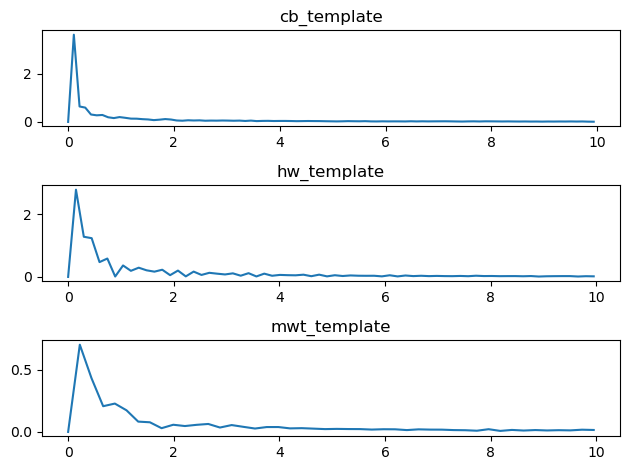

In [6]:
cb_template_fft = fftpack.fft(cb_template.mag_abs - np.mean(cb_template.mag_abs))
hw_template_fft = fftpack.fft(hw_template.mag_abs - np.mean(hw_template.mag_abs))
mwt_template_fft = fftpack.fft(mwt_template.mag_abs - np.mean(mwt_template.mag_abs))
cb_template_fftfreq = fftpack.fftfreq(len(cb_template_fft), d=cb_template.time_seq[1] - cb_template.time_seq[0])
hw_template_fftfreq = fftpack.fftfreq(len(hw_template_fft), d=hw_template.time_seq[1] - hw_template.time_seq[0])
mwt_template_fftfreq = fftpack.fftfreq(len(mwt_template_fft), d=mwt_template.time_seq[1] - mwt_template.time_seq[0])
cb_template_fftfreq, cb_template_fft = spectrum_cutoff(cb_template_fftfreq, cb_template_fft, 0, 10)
hw_template_fftfreq, hw_template_fft = spectrum_cutoff(hw_template_fftfreq, hw_template_fft, 0, 10)
mwt_template_fftfreq, mwt_template_fft = spectrum_cutoff(mwt_template_fftfreq, mwt_template_fft, 0, 10)
fig, axs = plt.subplots(3, 1)
axs[0].plot(cb_template_fftfreq, np.abs(cb_template_fft) / cb_template.mag_abs.shape[0])
axs[0].set_title("cb_template")
axs[1].plot(hw_template_fftfreq, np.abs(hw_template_fft) / hw_template.mag_abs.shape[0])
axs[1].set_title("hw_template")
axs[2].plot(mwt_template_fftfreq, np.abs(mwt_template_fft) / mwt_template.mag_abs.shape[0])
axs[2].set_title("mwt_template")
fig.tight_layout()

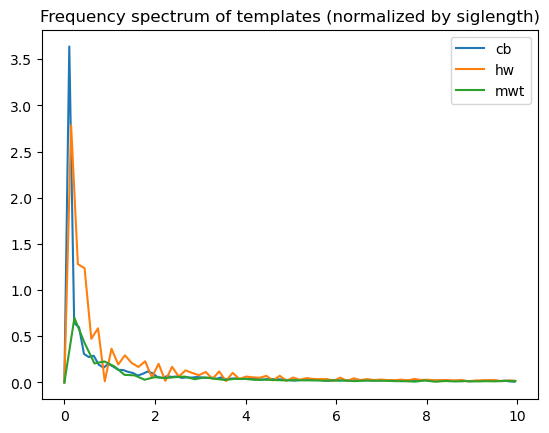

In [7]:
plt.plot(cb_template_fftfreq, np.abs(cb_template_fft) / cb_template.mag_abs.shape[0], label='cb')
plt.plot(hw_template_fftfreq, np.abs(hw_template_fft) / hw_template.mag_abs.shape[0], label='hw')
plt.plot(mwt_template_fftfreq, np.abs(mwt_template_fft) / mwt_template.mag_abs.shape[0], label='mwt')
plt.legend()
plt.title("Frequency spectrum of templates (normalized by siglength)")
plt.show()

We can see they are quite different! :)

cb_1f_traversal_maglocked_2023331_1952
cb_2f_traversal_maglocked_2023331_1954
cb_3f_traversal_maglocked_2023331_1957
cb_4f_traversal_maglocked_2023331_2003
cb_5f_traversal_maglocked_2023331_2005
cb_elevator_static_maglocked_2023331_2008
cb_g_traversal_maglocked_2023331_1945
cb_lg_traversal_maglocked_2023331_1949
composite_bldg_traversal_maglocked_2023331_2011
cpd_garden_traversal1_maglocked_2023331_1937
cpd_garden_traversal2_maglocked_2023331_1940


11it [00:00, 274.15it/s]


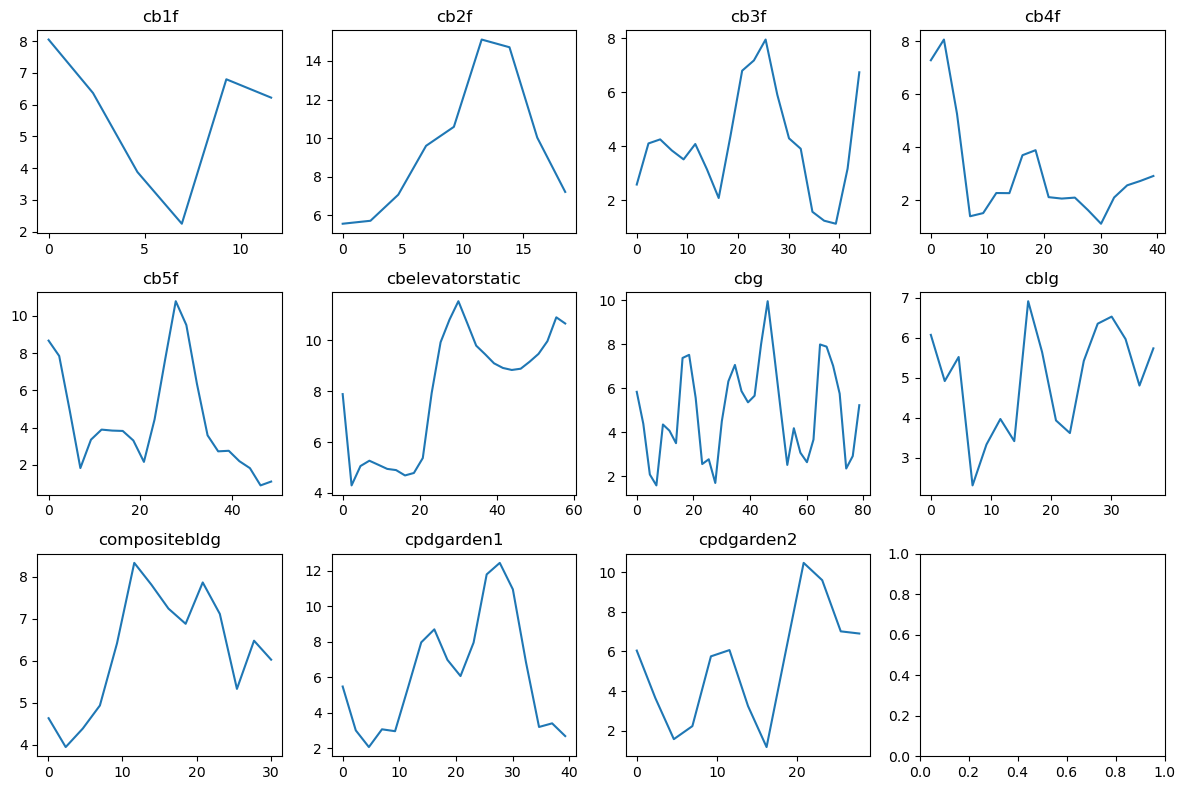

In [10]:
# First study: The CB G entrance.
template = api.get_template_data("cb_g_template_short_2023331_1941")
# We need data from Chow Yei Ching bldg and composite bldg and cpd garden, since they are very close!
maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cb"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "composite"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cpd_garden"])
for mt in maglocked_traversals:
    print(mt["title"])

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 4, idx % 4]
    timeseq, ds = tools.get_frequency_spectrum_similarity(template, mt_data, analysis_target='abs')
    # Normalize the euclidean distance by the length of the template.
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()

cym_1f_traversal_maglocked_202341_2008
cym_2f_traversal_maglocked_202341_2004
cym_3f_traversal_maglocked_202341_2002
cym_4f_traversal_maglocked_202341_1955
cym_5f_to_mwt_maglocked_202341_1939
cym_5f_via_escalator_mwt_crossreddoor_41s_maglocked_202341_1946


6it [00:00, 138.32it/s]


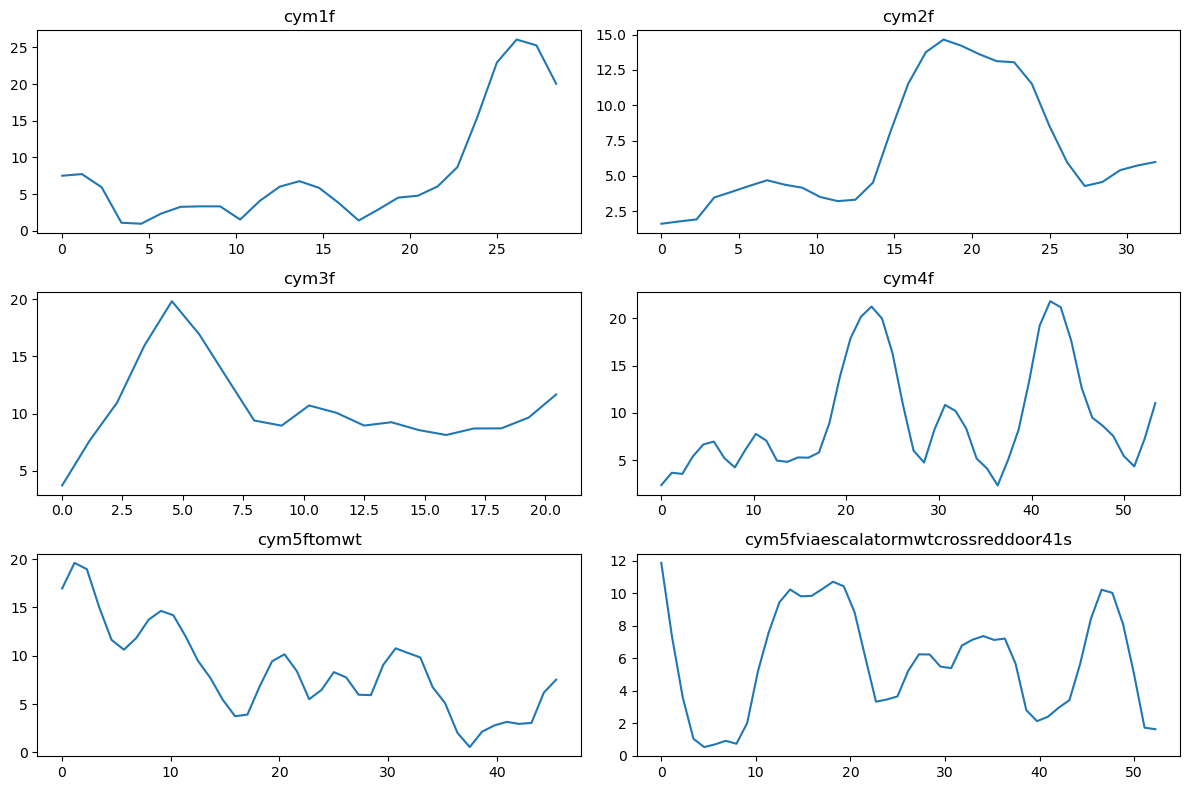

In [13]:
# The MWT experiment.
template = api.get_template_data("mwt_reddoor_template_maglocked_202341_1941")

maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cym"])
for mt in maglocked_traversals:
    print(mt["title"])

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 2, idx % 2]
    timeseq, ds = tools.get_frequency_spectrum_similarity(template, mt_data, analysis_target='abs')
    # Normalize the euclidean distance by the length of the template.
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()

aexit_to_hw_traversal_maglocked_2023331_2015
hw_1f_traversal_maglocked_202341_2030
hw_2f_traversal_maglocked_202341_2026
hw_3f_traversal_enter_at_8s_maglocked_202341_2021
hw_4f_su_backdoor_traversal_maglocked_202341_2036
hw_elevator_traversal_maglocked_202341_2033
composite_bldg_traversal_maglocked_2023331_2011


7it [00:00, 127.83it/s]


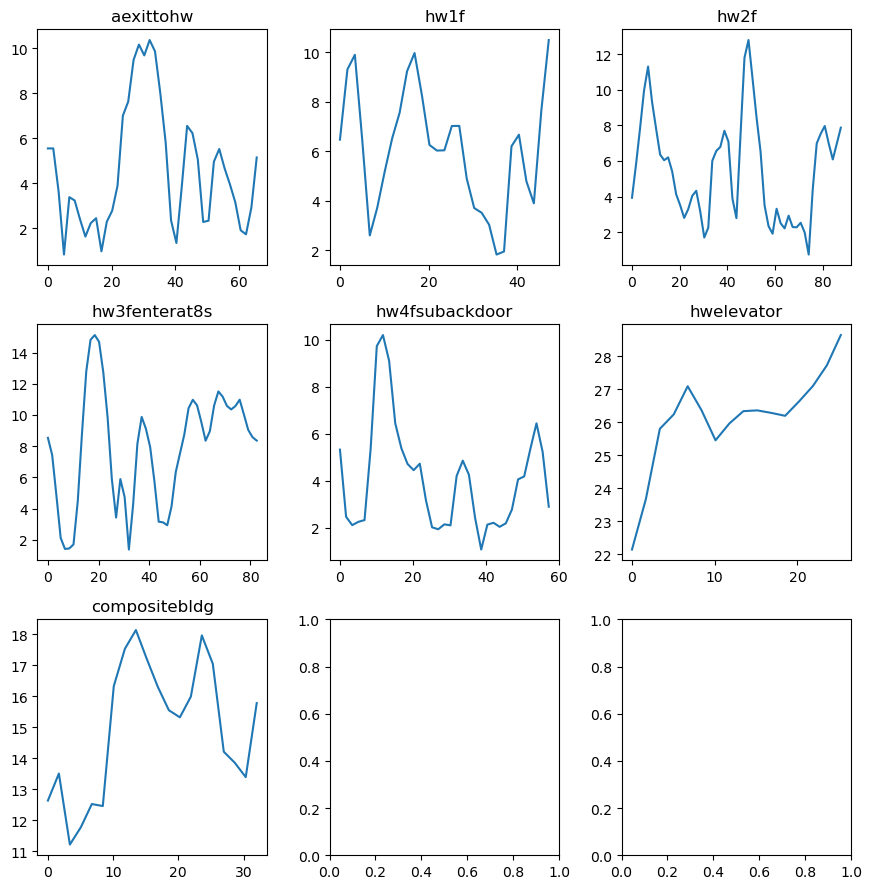

In [14]:
# The HW experiment.
template = api.get_template_data("hw_3f_door_template_maglocked_202341_2018")

maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "hw"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "composite"])
for mt in maglocked_traversals:
    print(mt["title"])

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 3, idx % 3]
    timeseq, ds = tools.get_frequency_spectrum_similarity(template, mt_data, analysis_target='abs')
    # Normalize the euclidean distance by the length of the template.
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()